# Autocorrelation methylation

---


## <span class="label label-success"> Analysis </span>

Proximal probes have similar methylation values. I will try to find the characteristic length of autocorrelation. 

I have dowloaded the annotation table from ncbi

---

## <span class="label label-warning">NOTE</span>


---


## <span class="label label-info">Conclusion</span>

~ 1000 bp long correlation of methylation -> sequence context should be 1000bp long !
- I can make shorter later 

---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import subprocess
import time

In [3]:
workdir='/nagyvinyok/adat84/sotejedlik/ribli/methylation_code/explore_data'
subprocess.call(['mkdir',workdir])
os.chdir(workdir)
os.environ['TMPDIR']='/nagyvinyok/adat84/sotejedlik/ribli/tmp'

In [4]:
#sql exetcuter func
def run_sqlilte3(command,db,output=''):
    start=time.time()
    with open('tempf.sql','w') as tempf:
        tempf.write(command)
        
    if output != '':
        output=' > '+output
    
    try:
        print subprocess.check_output('/usr/bin/sqlite3 '+ db + ' < tempf.sql '+ output,
                                      shell=True, stderr=subprocess.STDOUT)
    except subprocess.CalledProcessError, e:
        print e.output
    
    subprocess.call(['rm','tempf.sql'])
    print 'It took',int(time.time()-start),'s'

---
### Download, and load annotation table

In [8]:
%%bash

#download
#wget ftp://ftp.ncbi.nlm.nih.gov/geo/platforms/GPL13nnn/GPL13534/suppl/GPL13534%5FHumanMethylation450%5F15017482%5Fv%2E1%2E1%2Ecsv%2Egz

#unzip
#gunzip GPL13534_HumanMethylation450_15017482_v.1.1.csv.gz

#cut other tables from top and end
#tail -n +8 GPL13534_HumanMethylation450_15017482_v.1.1.csv | head -n 485578 > ncbi_450_annot.csv

In [9]:
run_sqlilte3("""
.separator ","

.import ncbi_450_annot.csv ncbi_450_annot

--delete missing values
DELETE FROM ncbi_450_annot WHERE CHR='' OR MAPINFO='' OR Strand='';

--create index
CREATE index id_idx ON ncbi_450_annot(IlmnID,CHR,MAPINFO,Strand);

""",db='../db/meth_db')


It took 18 s


#### Print  all probes with positions with median beta

In [10]:
run_sqlilte3('''
.separator "\t"
.load /home/ribli/tools/sqlite_math_ext/libsqlitefunctions

WITH med_table AS (
    SELECT probe AS probe,MEDIAN(beta) as medb
    FROM normal_h_meth
    GROUP BY probe)

SELECT n.CHR,n.MAPINFO,m.medb
FROM ncbi_450_annot AS n
INNER JOIN med_table AS m ON m.probe=n.IlmnID;

''',db='../db/meth_db',output='all_probes_pos_medb.csv')


It took 6 s


#### Load data

In [12]:
all_table=pd.read_csv('all_probes_pos_medb.csv',header=None,sep='\t',
                      names=['chr','pos','med'],dtype={'chr':object})

#### Just make a plot

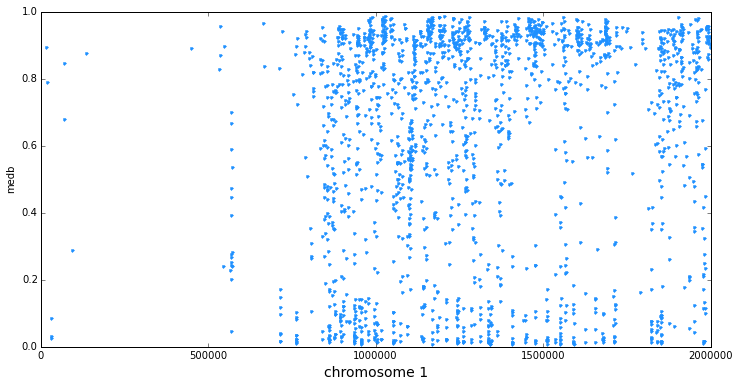

In [20]:
chrom='1'
temp_chrom_table=all_table[(all_table['chr']==chrom) & (all_table['pos']<2e6)][['pos','med']]
x=temp_chrom_table['pos'].values
med=temp_chrom_table['med'].values

fig,ax=plt.subplots()
fig.set_size_inches(12,6)

ax.plot(x,med,'.',c='dodgerblue')
ax.set_xlabel('chromosome '+chrom,fontsize=14)
dump=ax.set_ylabel('medb')

---
### Autocorrelatrion of mdiff
- non-uniform x-sampling! So this is not really correct
- chr1 0-120e6 will be enough, with no holes


#### Strong correlation with the 8-10 closest neighbours!
- median probe distance is around 300, this means ~ 1000 correlation length

#### Basin around 10-13?

----


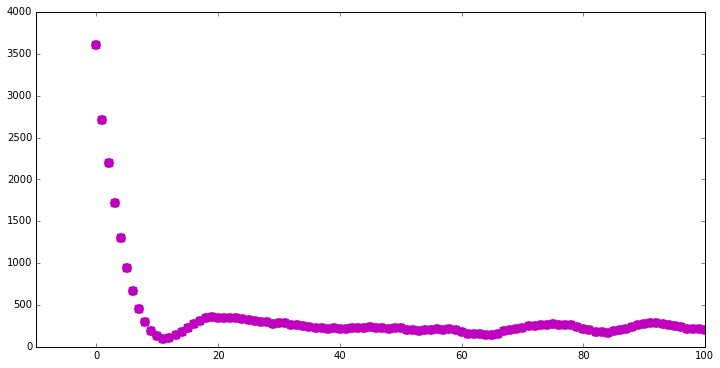

In [18]:
chrom='1'
temp_table=all_table[(all_table['chr']==chrom) & (all_table['pos']<120e6)][['pos','med']]
temp=temp_table.sort_values(by=['pos'])['med']-np.mean(temp_table['med'])
autocorr=np.correlate(temp,temp,mode='full')

fig,ax=plt.subplots()
fig.set_size_inches(12,6)
ax.plot(autocorr[autocorr.size/2:],'o',mec='none',c='m',ms=10)
ax.set_xlim(-10,100)
dump=ax.set_ylim(0)

##### Get median inter probe distance

In [19]:
x=temp_table.sort_values(by=['pos'])['pos']
np.median(x.values[1:]-x.values[:-1])

305.0